In [59]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [60]:
import yfinance as yf

data = yf.download(tickers = "GLD", start="2017-12-01", end="2023-06-16", interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,120.940002,122.430000,120.739998,121.589996,121.589996,13080100
2017-12-04,121.150002,121.199997,120.839996,121.180000,121.180000,6943700
2017-12-05,120.099998,120.510002,119.720001,120.320000,120.320000,10041200
2017-12-06,120.040001,120.440002,119.870003,120.070000,120.070000,6643000
2017-12-07,119.010002,119.239998,118.099998,118.489998,118.489998,12900200
...,...,...,...,...,...,...
2023-06-09,182.360001,182.789993,181.720001,182.039993,182.039993,4379200
2023-06-12,181.800003,181.940002,181.039993,181.880005,181.880005,4873600
2023-06-13,182.100006,182.429993,180.169998,180.539993,180.539993,5126700


In [61]:
data = data.reset_index('Date', inplace=False)

In [62]:
# Chuyển cột 'Date' thành kiểu dữ liệu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sắp xếp dữ liệu theo thứ tự tăng dần của cột 'Date'
data.sort_values(by='Date', inplace=True)

# Chuyển cột 'Date' thành mảng numpy
dates = data['Date'].values

# Chuyển cột 'Close' thành mảng numpy
close_prices = data['Close'].values

In [63]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [64]:
train_dates = train_data['Date'].values
train_close_prices = train_data['Close'].values
val_dates = val_data['Date'].values
val_close_prices = val_data['Close'].values
test_dates = test_data['Date'].values
test_close_prices = test_data['Close'].values

In [65]:
train_dates = train_data.index.values
test_dates = test_data.index.values
val_dates = val_data.index.values

In [66]:
X_train = torch.from_numpy(train_dates.reshape(-1, 1)).float()
y_train = torch.from_numpy(train_close_prices.reshape(-1, 1)).float()
X_test = torch.from_numpy(test_dates.reshape(-1, 1)).float()
y_test = torch.from_numpy(test_close_prices.reshape(-1, 1)).float()
X_val = torch.from_numpy(val_dates.reshape(-1, 1)).float()
y_val = torch.from_numpy(val_close_prices.reshape(-1, 1)).float()

In [67]:
# Xác định kiến trúc của mạng Bayesian Neural Network
class BNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [68]:
# Xác định hàm mất mát và bộ tối ưu hóa
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 1000

In [69]:
# Khởi tạo mô hình BNN
model = BNN(input_size=1, output_size=1)

In [70]:
# Huấn luyện mô hình BNN
for epoch in range(num_epochs):
    model.train()

    # Tính đầu ra dự đoán của mô hình
    y_pred = model(X_train)

    # Tính lỗi dự đoán so với giá thực tế
    loss = criterion(y_pred, y_train)

    # Backpropagation và cập nhật trọng số
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [100/1000], Loss: 10448.376953125
Epoch [200/1000], Loss: 7405.49853515625
Epoch [300/1000], Loss: 3587.79443359375
Epoch [400/1000], Loss: 3109.932861328125
Epoch [500/1000], Loss: 3090.618408203125
Epoch [600/1000], Loss: 3085.628662109375
Epoch [700/1000], Loss: 3074.77099609375
Epoch [800/1000], Loss: 3030.69091796875
Epoch [900/1000], Loss: 2972.143798828125
Epoch [1000/1000], Loss: 2918.220703125


In [71]:
# Dự đoán trên tập test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

In [72]:
# Dự đoán trên tập validation
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val)

In [73]:
# In kết quả dự đoán trên tập test
print('Kết quả dự đoán trên tập test:')
for i in range(len(test_dates)):
    print(f'Date: {test_dates[i]}, Predicted Close: {y_pred_test[i].item()}')

Kết quả dự đoán trên tập test:
Date: 975, Predicted Close: 233.7992401123047
Date: 976, Predicted Close: 234.03536987304688
Date: 977, Predicted Close: 234.27146911621094
Date: 978, Predicted Close: 234.50755310058594
Date: 979, Predicted Close: 234.7436981201172
Date: 980, Predicted Close: 234.9797821044922
Date: 981, Predicted Close: 235.21591186523438
Date: 982, Predicted Close: 235.45204162597656
Date: 983, Predicted Close: 235.6881561279297
Date: 984, Predicted Close: 235.92425537109375
Date: 985, Predicted Close: 236.16038513183594
Date: 986, Predicted Close: 236.39649963378906
Date: 987, Predicted Close: 236.63259887695312
Date: 988, Predicted Close: 236.86871337890625
Date: 989, Predicted Close: 237.1048583984375
Date: 990, Predicted Close: 237.3409423828125
Date: 991, Predicted Close: 237.5770721435547
Date: 992, Predicted Close: 237.8131866455078
Date: 993, Predicted Close: 238.04930114746094
Date: 994, Predicted Close: 238.28538513183594
Date: 995, Predicted Close: 238.52153

In [74]:
# In kết quả dự đoán trên tập validation
print('Kết quả dự đoán trên tập validation:')
for i in range(len(val_dates)):
    print(f'Date: {val_dates[i]}, Predicted Close: {y_pred_val[i].item()}')


Kết quả dự đoán trên tập validation:
Date: 1253, Predicted Close: 299.4389953613281
Date: 1254, Predicted Close: 299.67510986328125
Date: 1255, Predicted Close: 299.9112243652344
Date: 1256, Predicted Close: 300.1473388671875
Date: 1257, Predicted Close: 300.3834533691406
Date: 1258, Predicted Close: 300.6195373535156
Date: 1259, Predicted Close: 300.8556823730469
Date: 1260, Predicted Close: 301.091796875
Date: 1261, Predicted Close: 301.327880859375
Date: 1262, Predicted Close: 301.56402587890625
Date: 1263, Predicted Close: 301.8001403808594
Date: 1264, Predicted Close: 302.0362548828125
Date: 1265, Predicted Close: 302.27239990234375
Date: 1266, Predicted Close: 302.5084533691406
Date: 1267, Predicted Close: 302.7445983886719
Date: 1268, Predicted Close: 302.980712890625
Date: 1269, Predicted Close: 303.2168273925781
Date: 1270, Predicted Close: 303.4529113769531
Date: 1271, Predicted Close: 303.6890563964844
Date: 1272, Predicted Close: 303.9251708984375
Date: 1273, Predicted Clos

In [75]:
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
#x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

x_next_30_days = torch.from_numpy(np.array(range(last_index+1, last_index+31)).reshape(-1, 1)).float()
# Dự đoán giá đóng cửa cho 30 ngày tiếp theo
model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_30_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_30_days)):
    print(f'Date: {x_next_30_days[i]}, Predicted Close: {y_pred_next[i]}')

Date: tensor([1393.]), Predicted Close: 332.4949951171875
Date: tensor([1394.]), Predicted Close: 332.7310791015625
Date: tensor([1395.]), Predicted Close: 332.9671936035156
Date: tensor([1396.]), Predicted Close: 333.2033386230469
Date: tensor([1397.]), Predicted Close: 333.439453125
Date: tensor([1398.]), Predicted Close: 333.6755676269531
Date: tensor([1399.]), Predicted Close: 333.9116516113281
Date: tensor([1400.]), Predicted Close: 334.1477966308594
Date: tensor([1401.]), Predicted Close: 334.3839111328125
Date: tensor([1402.]), Predicted Close: 334.6200256347656
Date: tensor([1403.]), Predicted Close: 334.8561096191406
Date: tensor([1404.]), Predicted Close: 335.0922546386719
Date: tensor([1405.]), Predicted Close: 335.328369140625
Date: tensor([1406.]), Predicted Close: 335.564453125
Date: tensor([1407.]), Predicted Close: 335.80059814453125
Date: tensor([1408.]), Predicted Close: 336.0367126464844
Date: tensor([1409.]), Predicted Close: 336.2728271484375
Date: tensor([1410.]),

In [76]:
y_pred_test.type(),y_test.shape

('torch.FloatTensor', torch.Size([278, 1]))

In [77]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(torch.mean((y_pred_test - y_test)**2))
valid_rmse = np.sqrt(torch.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred_test, y_test)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: tensor(101.4068)
Validation RMSE: tensor(138.5093)
Testing MAE: 98.35926
Validation MAE: 138.39343
Testing MAPE: 0.36466232
Validation MAPE: 0.78128576


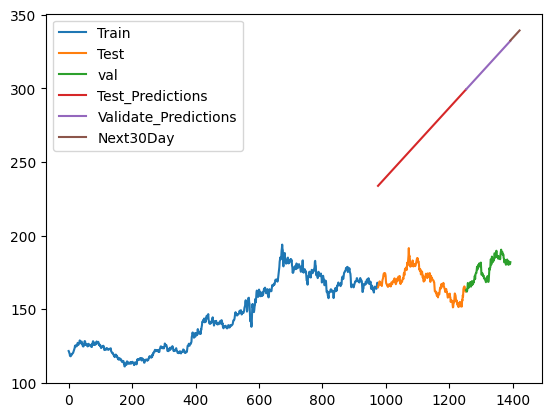

In [78]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data, y_pred_next)
plt.legend(['Train', 'Test','val', 'Test_Predictions','Validate_Predictions','Next30Day'])
plt.show()